## Tide Table for Cape Lookout

In [1]:
# Imports & Settings
import requests as req
import datetime as dt
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Get and format today's date
today = dt.date.today()
today_string = str(today).replace('-', '')

In [3]:
# Get the data
url = "https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={}&end_date={}&station=8656841&product=predictions&datum=MLLW&time_zone=lst&units=english&format=json".format(today_string, today_string)

data = req.get(url).json()  # Response object formatted as json 
predictions = data['predictions']  # List of Dictionaries
for prediction in predictions[0:5]:
    print(prediction)

{'t': '2021-04-10 00:00', 'v': '0.269'}
{'t': '2021-04-10 00:06', 'v': '0.273'}
{'t': '2021-04-10 00:12', 'v': '0.280'}
{'t': '2021-04-10 00:18', 'v': '0.292'}
{'t': '2021-04-10 00:24', 'v': '0.307'}


In [4]:
# Create Pandas DataFrame
predictions_df = pd.DataFrame.from_dict(data['predictions'])
predictions_df.head()

,t,v
0,2021-04-10 00:00,0.269
1,2021-04-10 00:06,0.273
2,2021-04-10 00:12,0.280
3,2021-04-10 00:18,0.292
4,2021-04-10 00:24,0.307


In [5]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   t       240 non-null    object
 1   v       240 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB


In [6]:
# Rename columns and change data types 
predictions_df.rename(columns={'t': 'hour', 'v': 'height'}, inplace=True)
predictions_df['hour'] = predictions_df['hour'].str[-5:-3].astype(int) + (predictions_df['hour'].str[-2:].astype(int))/60
predictions_df['height'] = predictions_df['height'].astype(float)
predictions_df.sort_values('hour')
predictions_df.head()

,hour,height
0,0.0,0.269
1,0.1,0.273
2,0.2,0.280
3,0.3,0.292
4,0.4,0.307


In [7]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hour    240 non-null    float64
 1   height  240 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


<AxesSubplot:title={'center':'Tide Graph\nApril 10, 2021'}, xlabel='hour', ylabel='height'>

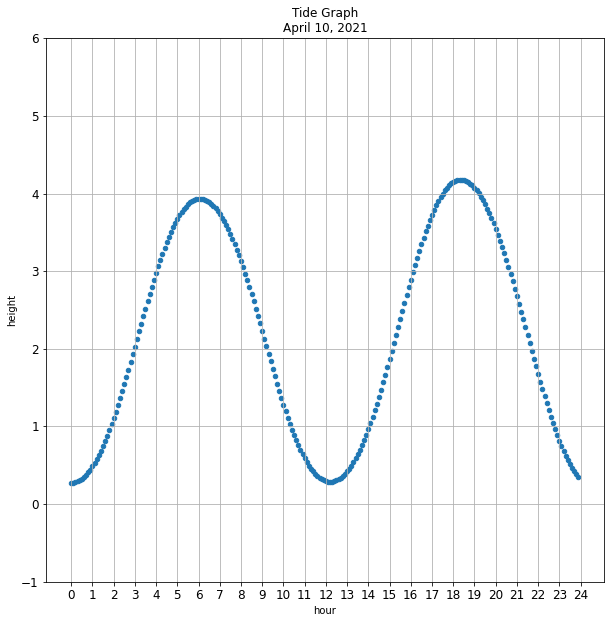

In [8]:
# Tide graph.
predictions_df.plot(kind='scatter',
                    x='hour', 
                    y='height', 
                    figsize=(10,10),
                    grid='both',
                    xticks=range(0,25),
                    ylim=(-1, 6),
                    title='Tide Graph\n{:%B %d, %Y}'.format(today),
                    fontsize=12,
                    marker='o')

In [9]:
# %matplotlib inline 
# plt.figure(figsize=(10, 10))
# plt.plot(predictions_df['hour'], predictions_df['height'], marker='o')
# plt.ylim(-1, 6)
# plt.title("Tide Graph\n{:%B %d, %Y}".format(today), fontsize=20)
# plt.grid(axis='both')
# plt.xticks(range(0, 25))
# plt.xlabel('hour')
# plt.show()

In [10]:
# Functions

def max_tide(series):
    """
    Returns list of indices for which 'height' is a relative maximum.
    """
    maxima = []
    for i in range(series.shape[0]-2):
        if series.iloc[i] <= series.iloc[i+1] and series.iloc[i+1] >= series.iloc[i+2]:
            maxima.append(i+1)
    return maxima
        
def min_tide(series):
    """
    Returns list of indices for which 'height' is a relative minimum.
    """
    minima = []
    for i in range(series.shape[0]-2):
        if series.iloc[i] >= series.iloc[i+1] and series.iloc[i+1] <= series.iloc[i+2]:
            minima.append(i+1) 
    return minima

def hour_to_time(hpm):
    """
    Converts 'hours past midnight' to 'time of day'.
    """
    h = int(hpm)
    m = int(round((hpm - h) * 60, 0))
    if h == 0 or h == 12:
        hour = '12' 
    else:
        hour = str(h % 12)
    if m < 10:
        minute = '0' + str(m)
    else: 
        minute = str(m)
    if h < 12:
        meridiam = 'AM'
    else:
        meridiam = 'PM'
    return  hour + ':' + minute + ' ' + meridiam

In [11]:
# Calculate times for high and low tides. 
maxima = max_tide(predictions_df['height'])
minima = min_tide(predictions_df['height'])

high_tide = predictions_df.iloc[maxima].copy()
high_tide.loc[:, 'event'] = 'High Tide'

low_tide = predictions_df.iloc[minima].copy() 
low_tide.loc[:, 'event'] = 'Low Tide'

tide_table = pd.concat([high_tide, low_tide], ignore_index=True)

tide_table['time'] = tide_table['hour'].apply(hour_to_time)
tide_table = tide_table[['time', 'hour', 'height', 'event']]
tide_table.sort_values('hour', inplace=True, ignore_index=True)
# tide_table.index = list(range(tide_table.shape[0]))
tide_table

,time,hour,height,event
0,6:00 AM,6.0,3.932,High Tide
1,6:06 AM,6.1,3.932,High Tide
2,12:12 PM,12.2,0.289,Low Tide
3,6:18 PM,18.3,4.180,High Tide
